In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow_addons as tfa


from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D


from sklearn.utils import shuffle
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score


from tqdm import tqdm
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler


from itertools import repeat
from itertools import product


from PIL import Image
from collections import Counter


import os
import gc
import cv2
import glob
import shutil
import random
import warnings
import itertools
import skimage.transform
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
PATH = '../../data/OCT'

# Paths
train_dir       = os.path.join(PATH, 'train/')
val_dir         = os.path.join(PATH, 'val/')
test_dir        = os.path.join(PATH, 'test/')

# Model and name
MODEL           = 'InceptionResNetV2'
NAME            = 'Oversampled' # Oversampled/Undersampled
AUG             = '' # Augmented
FULL_NAME       = MODEL
if NAME != '':
    FULL_NAME = MODEL + '_' + NAME
    if AUG != '':
        FULL_NAME = MODEL + '_' + NAME + '_' + AUG
elif AUG != '':
    FULL_NAME = MODEL + '_' + AUG
print('Check name:', FULL_NAME)

# Parameters
IMAGE_SIZE      = 150
INPUT_SHAPE     = (IMAGE_SIZE, IMAGE_SIZE, 3)
BATCH_SIZE      = 100
CLASSES         = ['CNV', 'DME', 'DRUSEN', 'NORMAL']
DICT_CLASSES    = {0: 'CNV', 1: 'DME', 2: 'DRUSEN', 3: 'NORMAL'}
COLORS          = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']

Check name: InceptionResNetV2_Oversampled


The size of  df_train_CNV  is (37113, 2) 
The size of  df_train_DME  is (11256, 2) 
The size of  df_train_DRUSEN  is (8524, 2) 
The size of  df_train_NORMAL  is (26223, 2) 


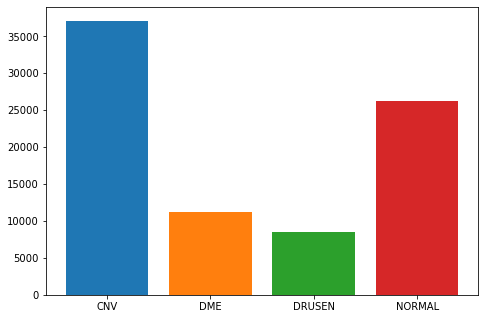

The size of  df_val_CNV  is (100, 2) 
The size of  df_val_DME  is (100, 2) 
The size of  df_val_DRUSEN  is (100, 2) 
The size of  df_val_NORMAL  is (100, 2) 


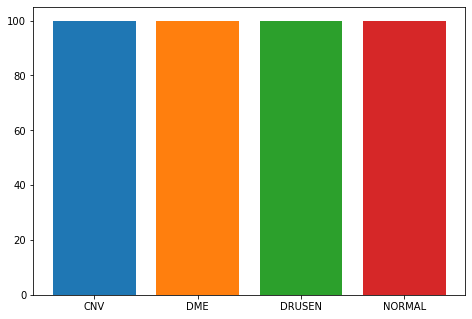

The size of  df_test_CNV  is (242, 2) 
The size of  df_test_DME  is (242, 2) 
The size of  df_test_DRUSEN  is (242, 2) 
The size of  df_test_NORMAL  is (242, 2) 


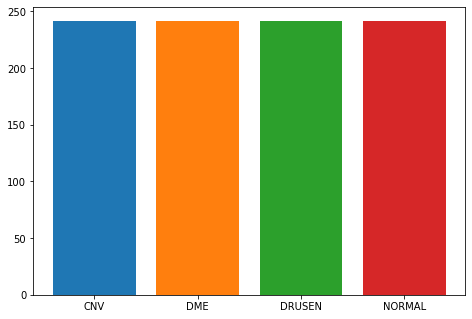

In [4]:
# load data, plot class distribution

def load_data(path, label, class_type):
    
    image_list = glob.glob(path + class_type + '/*')
    label_list = list(repeat(label, len(image_list)))
    
    data = list(zip(image_list,label_list))
    df = pd.DataFrame(data, columns = ['images', 'labels'])

    return df
        

def plot_dataset_imbalance(sample_distribution): 
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.bar(CLASSES, sample_distribution, color=COLORS)
    plt.show()
        
        
        
for dataset, path in list(zip(['train', 'val', 'test'], [train_dir, val_dir, test_dir])):
    for label,class_type in enumerate(CLASSES):
        df_var = "df_" + dataset + "_" + class_type
        vars()[df_var] = load_data(path, str(label), class_type)
        sample_size_var = "num_" + class_type
        vars()[sample_size_var] = vars()[df_var].shape[0]        
        print('The size of ', df_var, ' is {} '.format(vars()[df_var].shape))
    
    sample_distribution = [num_CNV, num_DME, num_DRUSEN, num_NORMAL]
    plot_dataset_imbalance(sample_distribution)

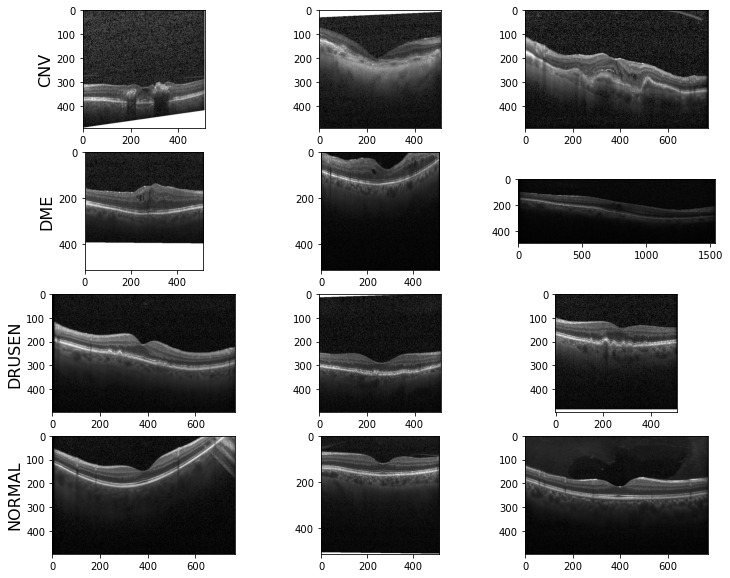

In [5]:
# plot randomly selected images of each class

fig=plt.figure(figsize=(12, 10))
cols = 3
rows = 4

for idx, rand_idx in enumerate(np.random.randint(0,1000, size=cols*rows)):
    class_type = CLASSES[int(idx/cols)]
    df_var = "df_train_" + class_type
    img = vars()[df_var]['images'][rand_idx]
    img = plt.imread(img)     
    ax = fig.add_subplot(rows, cols, idx+1)
    if idx%cols==0:
        plt.ylabel(CLASSES[int(idx/cols)], fontsize=16)
    plt.imshow(img, cmap='gist_gray')

In [6]:
def get_train_set(rebalance=0):
    
    if rebalance == 0:
        df_train_upsample = pd.concat([df_train_CNV, 
                               df_train_DME,
                               df_train_DRUSEN,
                               df_train_NORMAL], axis=0).reset_index(drop=True)
    else:
        df_train_upsample = pd.concat([df_train_CNV, 
                               #df_train_DME,
                               #df_train_DRUSEN,
                               df_train_DME, df_train_DME, 
                               df_train_DRUSEN, df_train_DRUSEN, 
                               df_train_NORMAL], axis=0).reset_index(drop=True)

    df_train = shuffle(df_train_upsample, random_state=42)
    print('The size of df_train is {}'.format(df_train.shape))
      
    return df_train

In [7]:
def get_test_set():
    
    df_test_combined = pd.concat([df_test_CNV, df_val_CNV, 
                                  df_test_DME, df_val_DME, 
                                  df_test_DRUSEN, df_val_DRUSEN,
                                  df_test_NORMAL, df_val_NORMAL], 
                                 axis=0).reset_index(drop=True)
    
    df_test = shuffle(df_test_combined, random_state=42)
    print('The size of df_test is {}'.format(df_test.shape))

    return df_test

In [8]:
def get_train_val_split_data(df_train, test_size=0.05):
    # split the train set into a train/val set

    # select the column that we will use for stratification
    y = df_train['labels']
    df_train, df_val = train_test_split(df_train, test_size=test_size, random_state=2020, stratify=y)

    print('The size of df_train is {}'.format(df_train.shape))
    print('The size of df_val is {}'.format(df_val.shape))
    
    return df_train, df_val

In [9]:
def plot_dataset_distribution(df_train, df_test):
    
    fig, ax = plt.subplots(1,2, figsize=(10, 6))

    for index,dataset in enumerate(['train', 'test']):
    
        df_var = "df_" + dataset 
        counts = vars()[df_var]['labels'].value_counts().sort_index()
        ax[index].pie(counts, labels=CLASSES, autopct='%.1f %%', colors=COLORS)
        ax[index].set_title( '{} set'.format(dataset))
    
    fig.suptitle('Class distribution for train and test datasets',
                 y=1.1, fontsize=16)
    fig.tight_layout()

In [10]:
def get_class_weights(verbose=1):
    
    counter = Counter(df_train.labels)                          
    max_count = float(max(counter.values()))  
    class_weights = {int(class_label) : max_count/num_images for class_label, 
                     num_images in counter.items()}                     
    if verbose:
        print('Class weights: \n', class_weights)
    return class_weights

In [11]:
def get_train_data(augmentation=0):
    
    if augmentation:
        train_datagen = ImageDataGenerator(rescale = 1/255.,
                                    rotation_range=20,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    fill_mode='nearest',
                                    zoom_range = 0.3,
                                    horizontal_flip = True)        
    else:    
        train_datagen = ImageDataGenerator(rescale=1./255)
        
    
    train_data= train_datagen.flow_from_dataframe(dataframe=df_train,
                                            directory=None,    # paths specified in x_col
                                            x_col="images", 
                                            y_col="labels", 
                                            class_mode="categorical",  # for multiclass
                                            seed=42,
                                            target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                            batch_size=BATCH_SIZE)
    return train_data

In [12]:
def get_valid_data():
    
    valid_datagen = ImageDataGenerator(rescale = 1/255.,)
    valid_data = valid_datagen.flow_from_dataframe(dataframe=df_val, 
                                             directory=None, 
                                             x_col="images", 
                                             y_col="labels", 
                                             class_mode="categorical",
                                             shuffle= True,
                                             target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                             batch_size=16)
    return valid_data

In [13]:
def get_test_data():
    
    test_datagen = ImageDataGenerator(rescale = 1/255.,)
    test_data = test_datagen.flow_from_dataframe(dataframe=df_test, 
                                             directory=None, 
                                             x_col="images", 
                                             y_col="labels", 
                                             class_mode="categorical",
                                             shuffle= False,
                                             target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                             batch_size=16)
    return test_data

The size of df_train is (102896, 2)
The size of df_train is (97751, 2)
The size of df_val is (5145, 2)
The size of df_test is (1368, 2)
Found 97751 validated image filenames belonging to 4 classes.
Found 5145 validated image filenames belonging to 4 classes.
Found 1368 validated image filenames belonging to 4 classes.
Class weights: 
 {2: 2.1768955297604347, 0: 1.0, 3: 1.415261721258831, 1: 1.648601889086318}


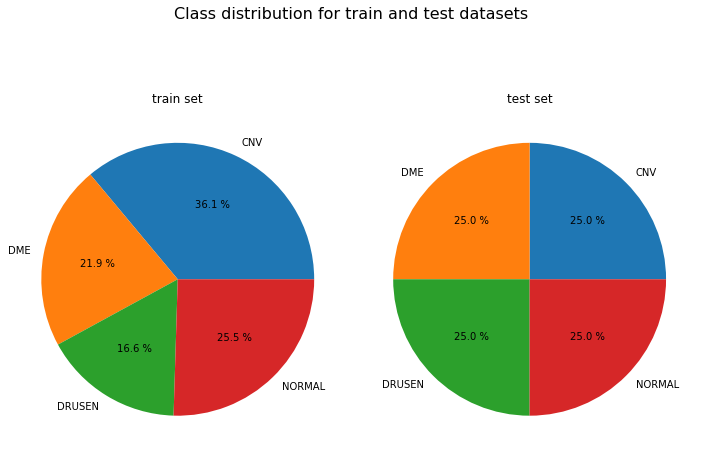

In [14]:
# Get different sets of data
df_train = get_train_set(rebalance=1)
df_train, df_val = get_train_val_split_data(df_train)
df_test = get_test_set()

train_data = get_train_data(augmentation=0)
valid_data = get_valid_data()
test_data = get_test_data()

# Get class weights
class_weights = get_class_weights()

plot_dataset_distribution(df_train, df_test) 

In [15]:
inception = tf.keras.applications.InceptionResNetV2(
    include_top = False, 
    weights = 'imagenet', 
    input_tensor = None,
    input_shape = INPUT_SHAPE, 
    pooling = None, 
    classes = 1000
)

inception.trainable = False

In [16]:
model = tf.keras.models.Sequential([
    inception,
    tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation = 'relu'),
    tf.keras.layers.Dense(4, activation = 'softmax')
])

In [17]:
metrics_list = ['accuracy',
                tf.keras.metrics.AUC(),
                #tfa.metrics.CohenKappa(num_classes = 4),
                tfa.metrics.F1Score(num_classes = 4)]

In [18]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = metrics_list)

In [19]:
history = model.fit(
    train_data,
    steps_per_epoch = train_data.samples // BATCH_SIZE,
    epochs = 10,
    class_weight = class_weights, 
    validation_data = valid_data,
    validation_steps=valid_data.samples // 16,
    verbose = 1
)

Epoch 1/10
977/977 [==============================] - 526s 524ms/step - loss: 1.3637 - accuracy: 0.6942 - auc: 0.8854 - f1_score: 0.6736 - val_loss: 0.4919 - val_accuracy: 0.8133 - val_auc: 0.9580 - val_f1_score: 0.7956
Epoch 2/10
977/977 [==============================] - 516s 528ms/step - loss: 0.6883 - accuracy: 0.8289 - auc: 0.9631 - f1_score: 0.8141 - val_loss: 0.4760 - val_accuracy: 0.8290 - val_auc: 0.9615 - val_f1_score: 0.8142
Epoch 3/10
977/977 [==============================] - 508s 520ms/step - loss: 0.5937 - accuracy: 0.8512 - auc: 0.9718 - f1_score: 0.8375 - val_loss: 0.4338 - val_accuracy: 0.8357 - val_auc: 0.9671 - val_f1_score: 0.8190
Epoch 4/10
977/977 [==============================] - 508s 520ms/step - loss: 0.5436 - accuracy: 0.8622 - auc: 0.9761 - f1_score: 0.8501 - val_loss: 0.4164 - val_accuracy: 0.8446 - val_auc: 0.9691 - val_f1_score: 0.8308
Epoch 5/10
977/977 [==============================] - 517s 529ms/step - loss: 0.4941 - accuracy: 0.8773 - auc: 0.9798 - 

In [20]:
def plot_curves(history, save_figure=True):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Accuracy' + ' | ' + FULL_NAME)

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0,1.0])
    plt.title('Training and Validation Loss' + ' | ' + FULL_NAME)
    plt.xlabel('Epoch')
    
    if save_figure:
        plt.savefig('../../img/' + MODEL + '/' + FULL_NAME + '.png',
            bbox_inches ="tight",
            transparent = True)
        
    plt.show()    

def plot_confusion_matrix(cm, 
                          classes,
                          title='Confusion Matrix',
                          cmap=plt.cm.Blues,
                          save_figure=True):
    
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy  
    
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=10)
    plt.yticks(tick_marks, classes, fontsize=10)
    
    plt.xlabel('Predicted label', fontsize=12)
    plt.ylabel('True label', fontsize=12)
    plt.title('Accuracy={:0.4f}; Misclass={:0.4f}'.format(accuracy, misclass), fontsize=14)
    plt.suptitle(title, fontsize=16)
    plt.colorbar()

    thresh = cm.max() / 2.0
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    if save_figure:
        plt.savefig('../../img/' + MODEL + '/' + FULL_NAME + '_cm.png',
            bbox_inches ="tight",
            transparent = True)

In [21]:
y_prob = model.predict(test_data, steps=len(test_data), verbose=1)
y_pred = np.argmax(y_prob,axis=1)
y_true = df_test['labels'].astype('int64').to_numpy()

86/86 [==============================] - 14s 133ms/step


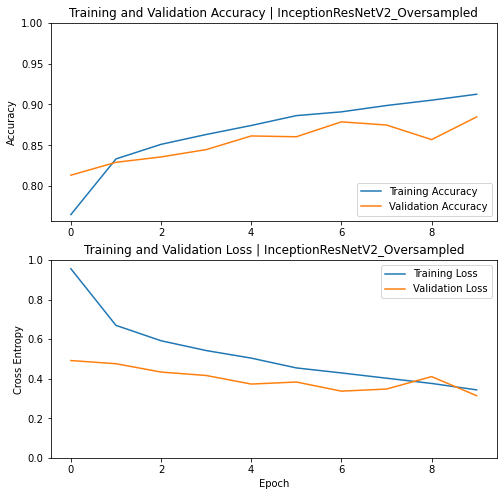

{0: 'CNV', 1: 'DME', 2: 'DRUSEN', 3: 'NORMAL'}
              precision    recall  f1-score   support

           0       0.92      0.95      0.93       342
           1       0.96      0.90      0.93       342
           2       0.93      0.90      0.92       342
           3       0.91      0.96      0.93       342

    accuracy                           0.93      1368
   macro avg       0.93      0.93      0.93      1368
weighted avg       0.93      0.93      0.93      1368

The accuracy is 0.9276315789473685


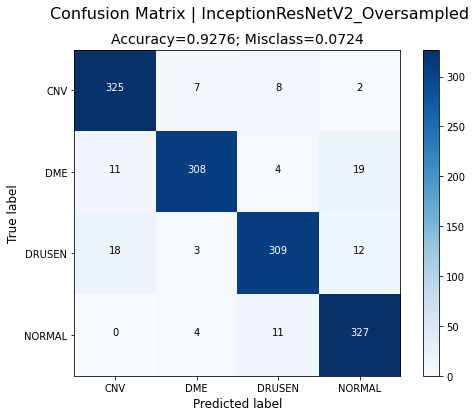

In [22]:
# Curves
plot_curves(history, save_figure=True)

# Confusion matrix
cm = confusion_matrix(y_true,y_pred)
classes = np.array(CLASSES)
title = 'Confusion Matrix' + ' | ' + FULL_NAME
plot_confusion_matrix(cm, classes, title, save_figure=True)

# Results
print(DICT_CLASSES)
print(classification_report(y_true, y_pred))
print('The accuracy is {}'.format(accuracy_score(y_true, y_pred)))